## Import Libraries Load data and clean

In [32]:
# Random Forest Regression
# Intall Libraries

#install numpy
#install pandas
#install matplotlib
#install seaborn
#install sklearn
#install statsmodels
#install openpyxl

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

from pyexpat import features

sns.set()  #if you want to use seaborn themes with matplotlib functions
import statsmodels.api as sm

import warnings

warnings.filterwarnings('ignore')



dfUnclean=pd.read_excel('F 1021 to 1025.xlsx')

In [33]:
#check that data looks allright
dfUnclean.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2025-10-21,12.26,12.63,12.07,12.56,12.56,297006962.0
1,2025-10-20,11.93,12.08,11.91,11.99,11.99,77878900.0
2,2025-10-17,11.74,12.01,11.72,11.92,11.92,107633500.0
3,2025-10-16,11.74,11.79,11.64,11.74,11.74,108701200.0
4,2025-10-15,11.68,11.78,11.64,11.76,11.76,88960700.0


In [34]:
# There are dividends paid and as such there are more dates and "open values" but in reality those are the dividend amounts
dfUnclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1020 non-null   datetime64[ns]
 1   Open       1020 non-null   object        
 2   High       1004 non-null   float64       
 3   Low        1004 non-null   float64       
 4   Close      1004 non-null   float64       
 5   Adj Close  1004 non-null   float64       
 6   Volume     1004 non-null   float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 55.9+ KB


In [35]:
# Show sample rows where any column has 'Dividend'
div_check = dfUnclean[dfUnclean.apply(lambda row: row.astype(str).str.contains("Dividend", case=False, na=False).any(), axis=1)]

print(div_check)

          Date           Open  High  Low  Close  Adj Close  Volume
50  2025-08-11  0.15 Dividend   NaN  NaN    NaN        NaN     NaN
113 2025-05-12  0.15 Dividend   NaN  NaN    NaN        NaN     NaN
172 2025-02-18   0.3 Dividend   NaN  NaN    NaN        NaN     NaN
240 2024-11-07  0.15 Dividend   NaN  NaN    NaN        NaN     NaN
306 2024-08-07  0.15 Dividend   NaN  NaN    NaN        NaN     NaN
370 2024-05-07  0.15 Dividend   NaN  NaN    NaN        NaN     NaN
427 2024-02-15  0.33 Dividend   NaN  NaN    NaN        NaN     NaN
501 2023-10-31  0.15 Dividend   NaN  NaN    NaN        NaN     NaN
572 2023-07-24  0.15 Dividend   NaN  NaN    NaN        NaN     NaN
634 2023-04-25  0.15 Dividend   NaN  NaN    NaN        NaN     NaN
685 2023-02-10   0.8 Dividend   NaN  NaN    NaN        NaN     NaN
746 2022-11-14  0.15 Dividend   NaN  NaN    NaN        NaN     NaN
814 2022-08-10  0.15 Dividend   NaN  NaN    NaN        NaN     NaN
889 2022-04-25   0.1 Dividend   NaN  NaN    NaN        NaN    

In [36]:
# Identify dividend rows
div_mask = dfUnclean["Open"].astype(str).str.contains("Dividend", case=False, na=False)

div_rows = dfUnclean[div_mask]
price_rows = dfUnclean[~div_mask]

# Extract dividend amount
div_rows["Dividend"] = div_rows["Open"].astype(str).str.extract(r"([0-9]*\.?[0-9]+)").astype(float)
div_rows = div_rows[["Date", "Dividend"]]

# Convert Date to datet
div_rows["Date"] = pd.to_datetime(div_rows["Date"])
price_rows["Date"] = pd.to_datetime(price_rows["Date"])

dfUnclean = price_rows.merge(div_rows, on="Date", how="left")

if(dfUnclean["Dividend"].isna().any()==True):
    dfUnclean["Dividend"] = dfUnclean["Dividend"].fillna(0)

#convert volume to int
dfUnclean["Volume"] = dfUnclean["Volume"].astype(int)

df = dfUnclean

print(df.iloc[50])


Date         2025-08-11 00:00:00
Open                        11.3
High                       11.57
Low                        11.06
Close                      11.14
Adj Close                  11.14
Volume                  84333000
Dividend                    0.15
Name: 50, dtype: object


In [37]:
#Check for missing data
df.info()
df.isnull().sum()/len(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1004 entries, 0 to 1003
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1004 non-null   datetime64[ns]
 1   Open       1004 non-null   object        
 2   High       1004 non-null   float64       
 3   Low        1004 non-null   float64       
 4   Close      1004 non-null   float64       
 5   Adj Close  1004 non-null   float64       
 6   Volume     1004 non-null   int64         
 7   Dividend   1004 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 62.9+ KB


Date         0.0
Open         0.0
High         0.0
Low          0.0
Close        0.0
Adj Close    0.0
Volume       0.0
Dividend     0.0
dtype: float64

In [38]:
#check for duplicates
sum(df.duplicated())
df.nunique()

Date         1004
Open          551
High          541
Low           547
Close         561
Adj Close     458
Volume       1004
Dividend        6
dtype: int64

## Adding Autoregressive Varriables

In [39]:
def create_lagged_features(df, lags, cols):
    for col in cols:
        for i in range(1,lags+1):
            df[f'{col}_lag_{i}'] = df[col].shift(i)

    return df


In [40]:
dfCopy =df.copy()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividend
0,2025-10-21,12.26,12.63,12.07,12.56,12.56,297006962,0.0
1,2025-10-20,11.93,12.08,11.91,11.99,11.99,77878900,0.0
2,2025-10-17,11.74,12.01,11.72,11.92,11.92,107633500,0.0
3,2025-10-16,11.74,11.79,11.64,11.74,11.74,108701200,0.0
4,2025-10-15,11.68,11.78,11.64,11.76,11.76,88960700,0.0


In [41]:
lag_features = ['Volume', 'Open', 'Close']
create_lagged_features(df, lags=2, cols=lag_features)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Dividend,Volume_lag_1,Volume_lag_2,Open_lag_1,Open_lag_2,Close_lag_1,Close_lag_2
0,2025-10-21,12.26,12.63,12.07,12.56,12.56,297006962,0.0,NaN,NaN,None,None,NaN,NaN
1,2025-10-20,11.93,12.08,11.91,11.99,11.99,77878900,0.0,297006962.0,NaN,12.26,None,12.56,NaN
2,2025-10-17,11.74,12.01,11.72,11.92,11.92,107633500,0.0,77878900.0,297006962.0,11.93,12.26,11.99,12.56
3,2025-10-16,11.74,11.79,11.64,11.74,11.74,108701200,0.0,107633500.0,77878900.0,11.74,11.93,11.92,11.99
4,2025-10-15,11.68,11.78,11.64,11.76,11.76,88960700,0.0,108701200.0,107633500.0,11.74,11.74,11.74,11.92


In [42]:
df.head

<bound method NDFrame.head of            Date   Open   High    Low  Close  Adj Close     Volume  Dividend  \
0    2025-10-21  12.26  12.63  12.07  12.56      12.56  297006962       0.0   
1    2025-10-20  11.93  12.08  11.91  11.99      11.99   77878900       0.0   
2    2025-10-17  11.74  12.01  11.72  11.92      11.92  107633500       0.0   
3    2025-10-16  11.74  11.79  11.64  11.74      11.74  108701200       0.0   
4    2025-10-15  11.68  11.78  11.64  11.76      11.76   88960700       0.0   
...         ...    ...    ...    ...    ...        ...        ...       ...   
999  2021-10-27  15.79  15.92  15.50  15.51      11.90   96094300       0.0   
1000 2021-10-26  16.09  16.22  15.70  15.94      12.23   64882300       0.0   
1001 2021-10-25   16.4  16.50  15.81  16.00      12.28   67808000       0.0   
1002 2021-10-22  16.42  16.54  16.23  16.28      12.50   60646800       0.0   
1003 2021-10-21  16.16  16.70  16.13  16.55      12.70   95855000       0.0   

      Volume_lag_1  V

## Splitting Data into Training and Test

In [57]:
target = "Close"

# All columns that contain "_lag_" become features
Y = df[target]
X = df[[c for c in df.columns if "_lag_" in c]+ [c for c in df.columns if c not in lag_features and c not in ["Date", "Adj Close","High","Low", target]]]

#20% of data to test
#Double check that its the newest data that is being used for the test
split = int(len(df) * 0.2)

X_train, X_test = X.iloc[split:], X.iloc[:split]
Y_train, Y_test = Y.iloc[split:], Y.iloc[:split]


In [58]:
#Check that Data was split right
print(f"X_train Length {len(X_train)}")
print(f"X_test Length {len(X_test)}")
print(f"Y_train Length {len(Y_train)}")
print(f"Y_test Length {len(Y_test)}")

X_train Length 804
X_test Length 200
Y_train Length 804
Y_test Length 200


## Create the Model

In [60]:
from sklearn.ensemble import RandomForestRegressor


model = RandomForestRegressor(
    n_estimators=1000,
    max_depth=50,
    random_state=25565
)

model.fit(X_train, Y_train)


,n_estimators,1000
,criterion,'squared_error'
,max_depth,50
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [61]:
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

## Test the models accuracy

In [63]:
def evaluate(Y_true, Y_pred):
    mae = mean_absolute_error(Y_true, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_true, Y_pred))
    r2 = r2_score(Y_true, Y_pred)

    return mae, rmse, r2

train_mae, train_rmse, train_r2 = evaluate(Y_train, Y_pred_train)
test_mae, test_rmse, test_r2 = evaluate(Y_test, Y_pred_test)

print("TRAINING PERFORMANCE:")
print(f"MAE:  {train_mae:.4f}")
print(f"RMSE: {train_rmse:.4f}")
print(f"R²:   {train_r2:.4f}")

print("\nTEST PERFORMANCE:")
print(f"MAE:  {test_mae:.4f}")
print(f"RMSE: {test_rmse:.4f}")
print(f"R²:   {test_r2:.4f}")

TRAINING PERFORMANCE:
MAE:  0.0614
RMSE: 0.0988
R²:   0.9988

TEST PERFORMANCE:
MAE:  0.1575
RMSE: 0.2382
R²:   0.9305


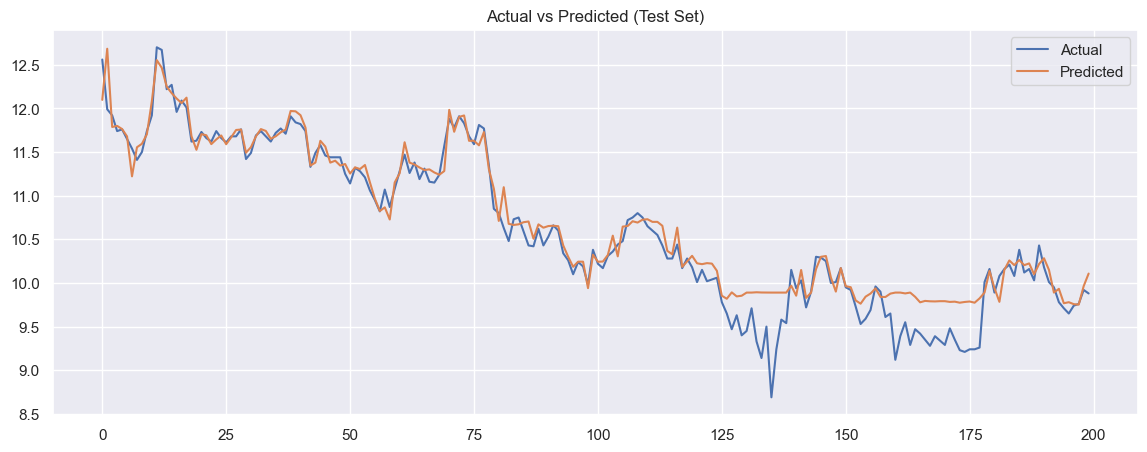

In [64]:
plt.figure(figsize=(14,5))
plt.plot(Y_test.values, label="Actual")
plt.plot(Y_pred_test, label="Predicted")
plt.title("Actual vs Predicted (Test Set)")
plt.legend()
plt.show()

In [49]:
importance = pd.Series(model.feature_importances_, index=X_train.columns)
importance.sort_values(ascending=False).head(20)


Low             3.900699e-01
High            2.914825e-01
Open_lag_1      1.621607e-01
Open_lag_1      1.399073e-01
Close_lag_1     6.063644e-03
Close_lag_1     3.584986e-03
Open_lag_2      2.820103e-03
Open_lag_2      2.101629e-03
Close_lag_2     9.106471e-04
Close_lag_2     4.769085e-04
Volume_lag_1    1.195164e-04
Volume_lag_1    1.111136e-04
Volume_lag_2    9.689773e-05
Volume_lag_2    9.339010e-05
Dividend        7.640690e-07
dtype: float64

<Axes: >

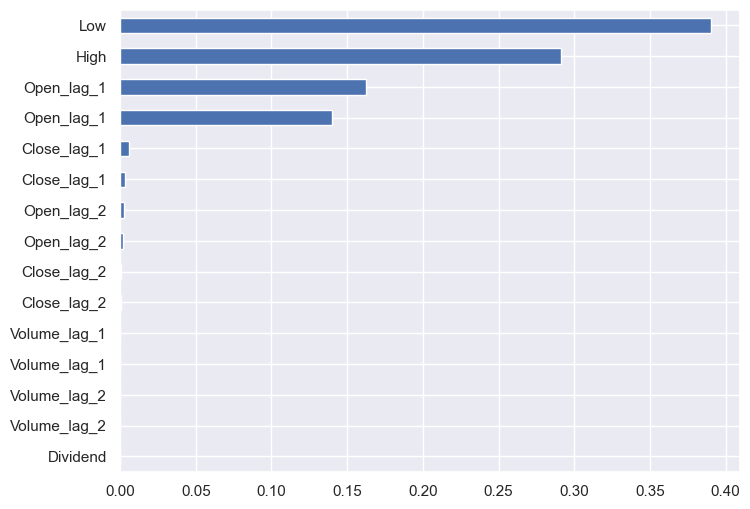

In [50]:
importance.sort_values().tail(20).plot(kind='barh', figsize=(8,6))

## Walk forward multi-horizon testing 1,5,10,20,30,60,90 Days into the future

In [51]:
def walk_forward_horizon_test(model, X, Y,horizons):

    results = {}

    for h in horizons:

        preds = []
        actuals = []

        for i in range(len(X) - h):
            # Predict based on the feature row i
            pred = model.predict([X.iloc[i].values])[0]
            actual = Y.iloc[i + h]

            preds.append(pred)
            actuals.append(actual)

        mae = mean_absolute_error(actuals, preds)
        rmse = np.sqrt(mean_squared_error(actuals, preds))


        results[h] = {"MAE": mae, "RMSE": rmse}

    return results

In [55]:
horizons =[1,5]#,10,20,30,60,90]
results = walk_forward_horizon_test(model, X_test, Y_test, horizons)

for h, metrics in results.items():
    print(f"{h}-DAY FORECAST:")
    print(f"MAE:  {metrics['MAE']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}\n")


NameError: name 'r2' is not defined

In [321]:
def evaluate_multi_step_forecast(model, X_test, Y_test, max_horizon=10):

    results = []

    for horizon in range(1, max_horizon + 1):

        preds = []
        actuals = []

        # For each starting point, iteratively forecast ahead
        for i in range(len(X_test) - horizon):

            X_input = X_test.iloc[i].copy()

            # Iteratively predict up to the chosen horizon
            for step in range(horizon):
                pred = model.predict(X_input.values.reshape(1, -1))[0]

                # shift autoregressive variables
                if "Close_lag1" in X_input.index:
                    X_input["Close_lag1"] = pred
                if "Open_lag1" in X_input.index:
                    X_input["Open_lag1"] = pred
                if "Volume_lag1" in X_input.index:
                    X_input["Volume_lag1"] = pred

            preds.append(pred)
            actuals.append(Y_test.iloc[i + horizon])

        preds = np.array(preds)
        actuals = np.array(actuals)

        mae = mean_absolute_error(actuals, preds)
        rmse = np.sqrt(mean_squared_error(actuals, preds))
        r2 = r2_score(actuals, preds)

        results.append([horizon, mae, rmse, r2])

    return pd.DataFrame(results, columns=["Horizon", "MAE", "RMSE", "R2"])

In [322]:
results = evaluate_multi_step_forecast(model, X_test, y_test, max_horizon=10)
print(results)

   Horizon       MAE      RMSE        R2
0        1  6.045993  7.301189 -3.437608
1        2  6.048838  7.308274 -3.425321
2        3  6.055673  7.316080 -3.415840
3        4  6.066381  7.324741 -3.406973
4        5  6.075217  7.333379 -3.396643
5        6  6.080401  7.343850 -3.390889
6        7  6.087358  7.354770 -3.384631
7        8  6.099724  7.366787 -3.383638
8        9  6.111886  7.379788 -3.389829
9       10  6.126499  7.393675 -3.406624
